In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.m4_evaluation_loss_functions import *
from src.training_loss_functions import *
from src.visualization import *
from src.evaluation import *
from src.data_augmentations import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [2]:
EPOCHS = 50
BATCH_SIZE = 128
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 120
HIDDEN_LAYERS = 6
FEATURES_NUMBER = 2
CLIP_VALUE = 2
LEARNING_RATE = 0.002
DROPOUT_RATIO = 0.2

OUTPUT_SIZE = HORIZON*2
LOSS = kl_divergance
PI_PARAMS = {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}

stdAugmentation = StdAugmentation(PI_PARAMS)
diffAugmentation = DiffAugmentation()
x_augmentations = [stdAugmentation]
y_augmentations = [stdAugmentation]

TRAIN_PATH = "../Dataset/splitted/Hourly-train.csv"
TEST_PATH = "../Dataset/splitted/Hourly-test.csv"
TRAIN_HOLDOUT_PATH = "../Dataset/splitted/Hourly-train-holdout.csv"
TEST_HOLDOUT_PATH= "../Dataset/splitted/Hourly-test-holdout.csv"

data_loader = M4DataLoader(TRAIN_PATH, TEST_PATH, TRAIN_HOLDOUT_PATH, TEST_HOLDOUT_PATH,
                           x_augmentations, y_augmentations, LOOKBACK, HORIZON)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
holdout_x, holdout_y = data_loader.get_holdout_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
holdout_data_generator = M4Generator(holdout_x, holdout_y, BATCH_SIZE, FEATURES_NUMBER)

# Train The Model

In [3]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, hidden_layers=HIDDEN_LAYERS,
                batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=LEARNING_RATE, loss = LOSS,
                dropout_ratio = DROPOUT_RATIO, features_number = FEATURES_NUMBER, 
                clipvalue=CLIP_VALUE, callbacks = [], pi_params=PI_PARAMS)

In [4]:
model.train(training_data_generator, test_data_generator, epochs=5)

Epoch 1/5
41/41 [==============================] - 43s 1s/step - loss: 12027794.2403 - val_loss: 287.6407
Epoch 2/5
 9/41 [=====>........................] - ETA: 31s - loss: 3603715.8647

KeyboardInterrupt: 

# Save The Model

In [6]:
MODEL_BASE_DIR = '../models/kl_divergance/10-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/kl_divergance/10-LSTM/2


# Get Best And Worst Predictions

Loaded model from disk
Best Predection Error is     0.7137
Worst Predection Error is     9.1103


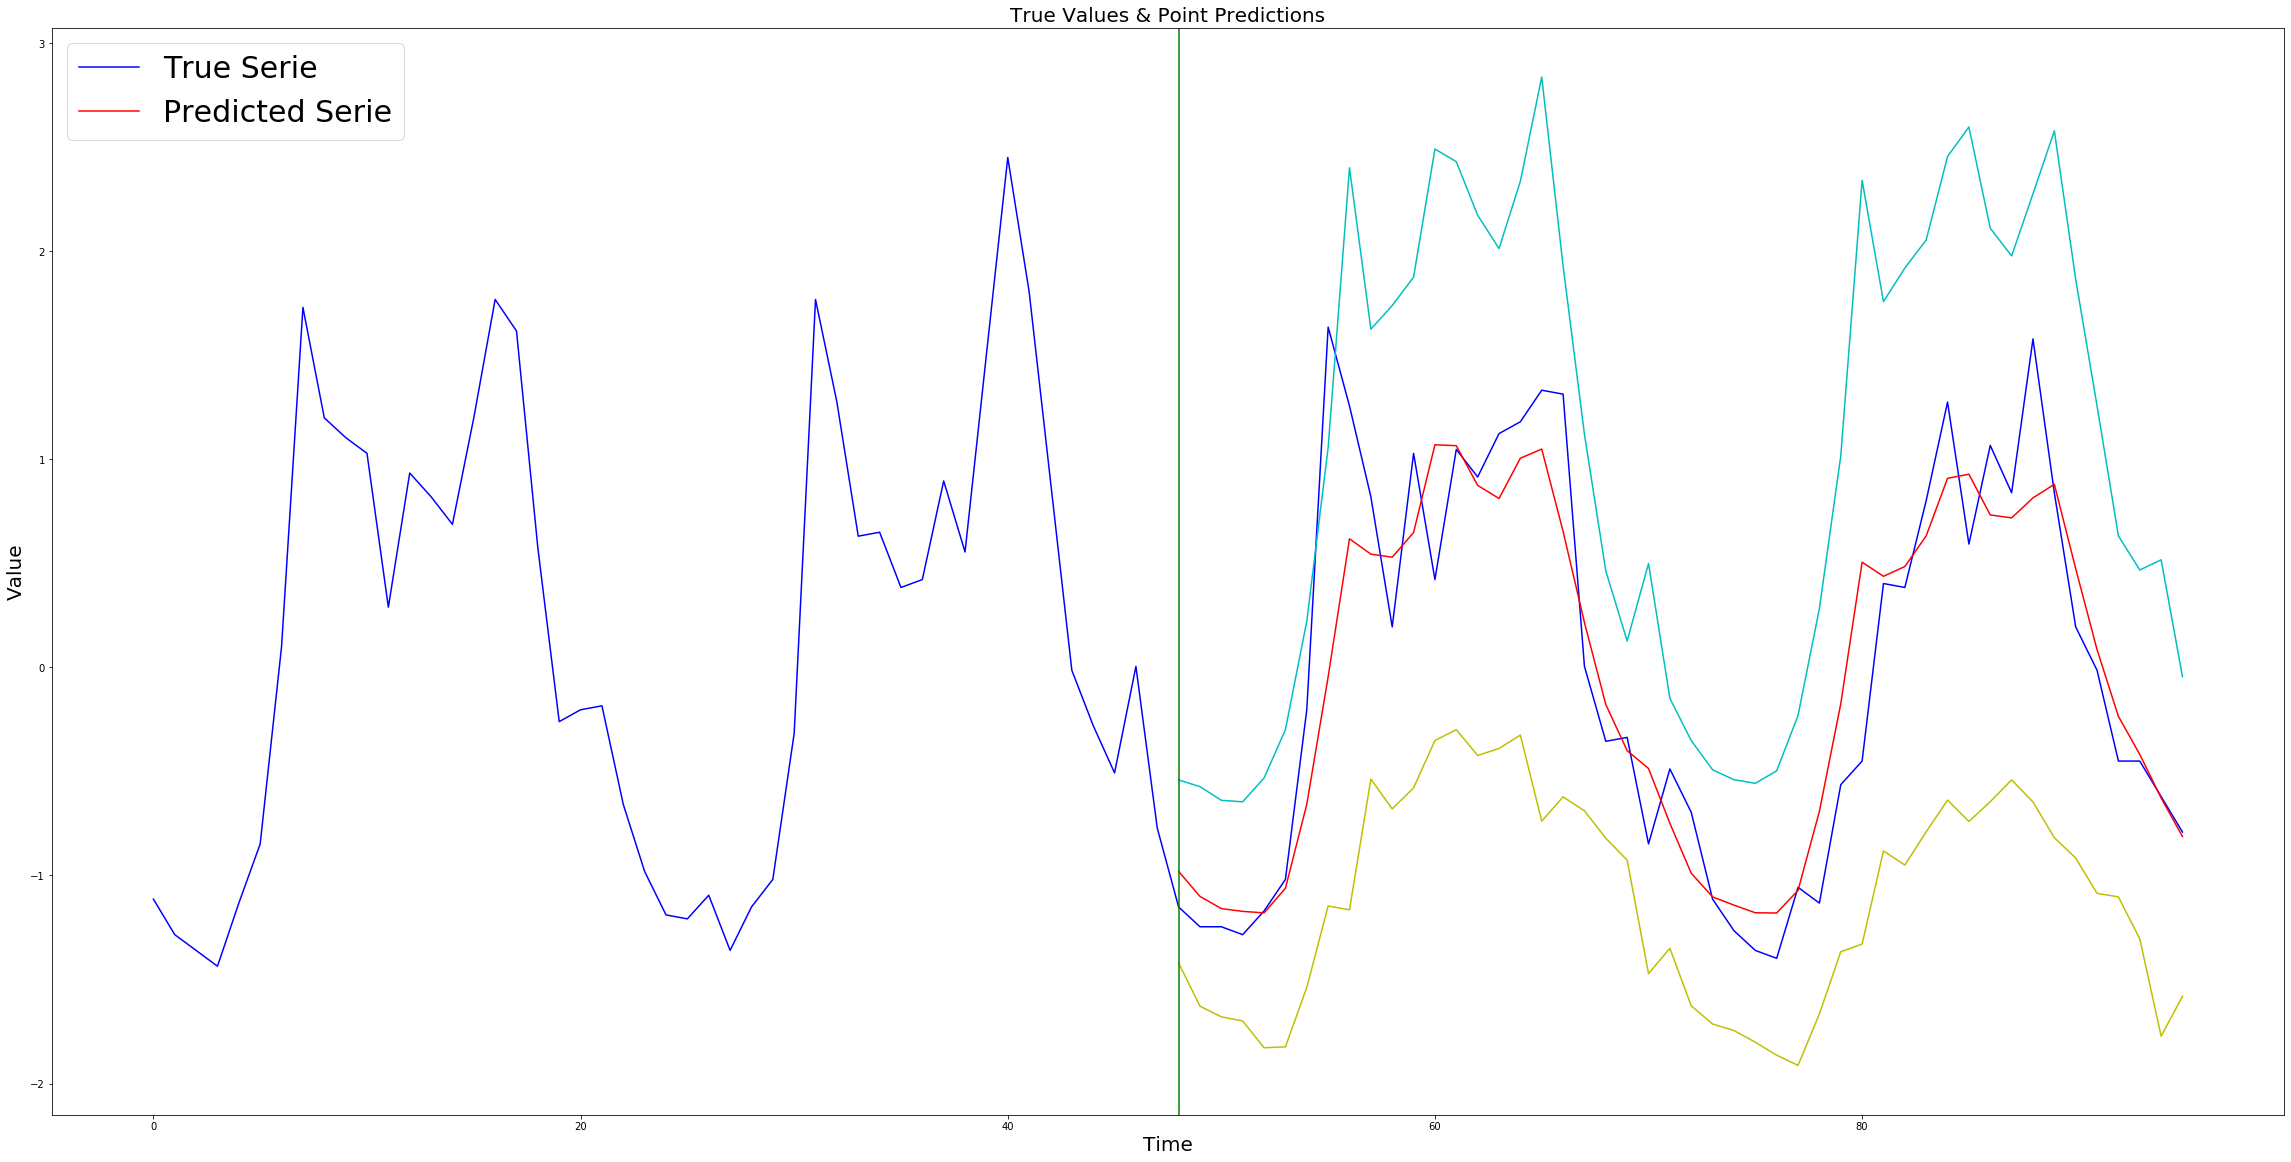

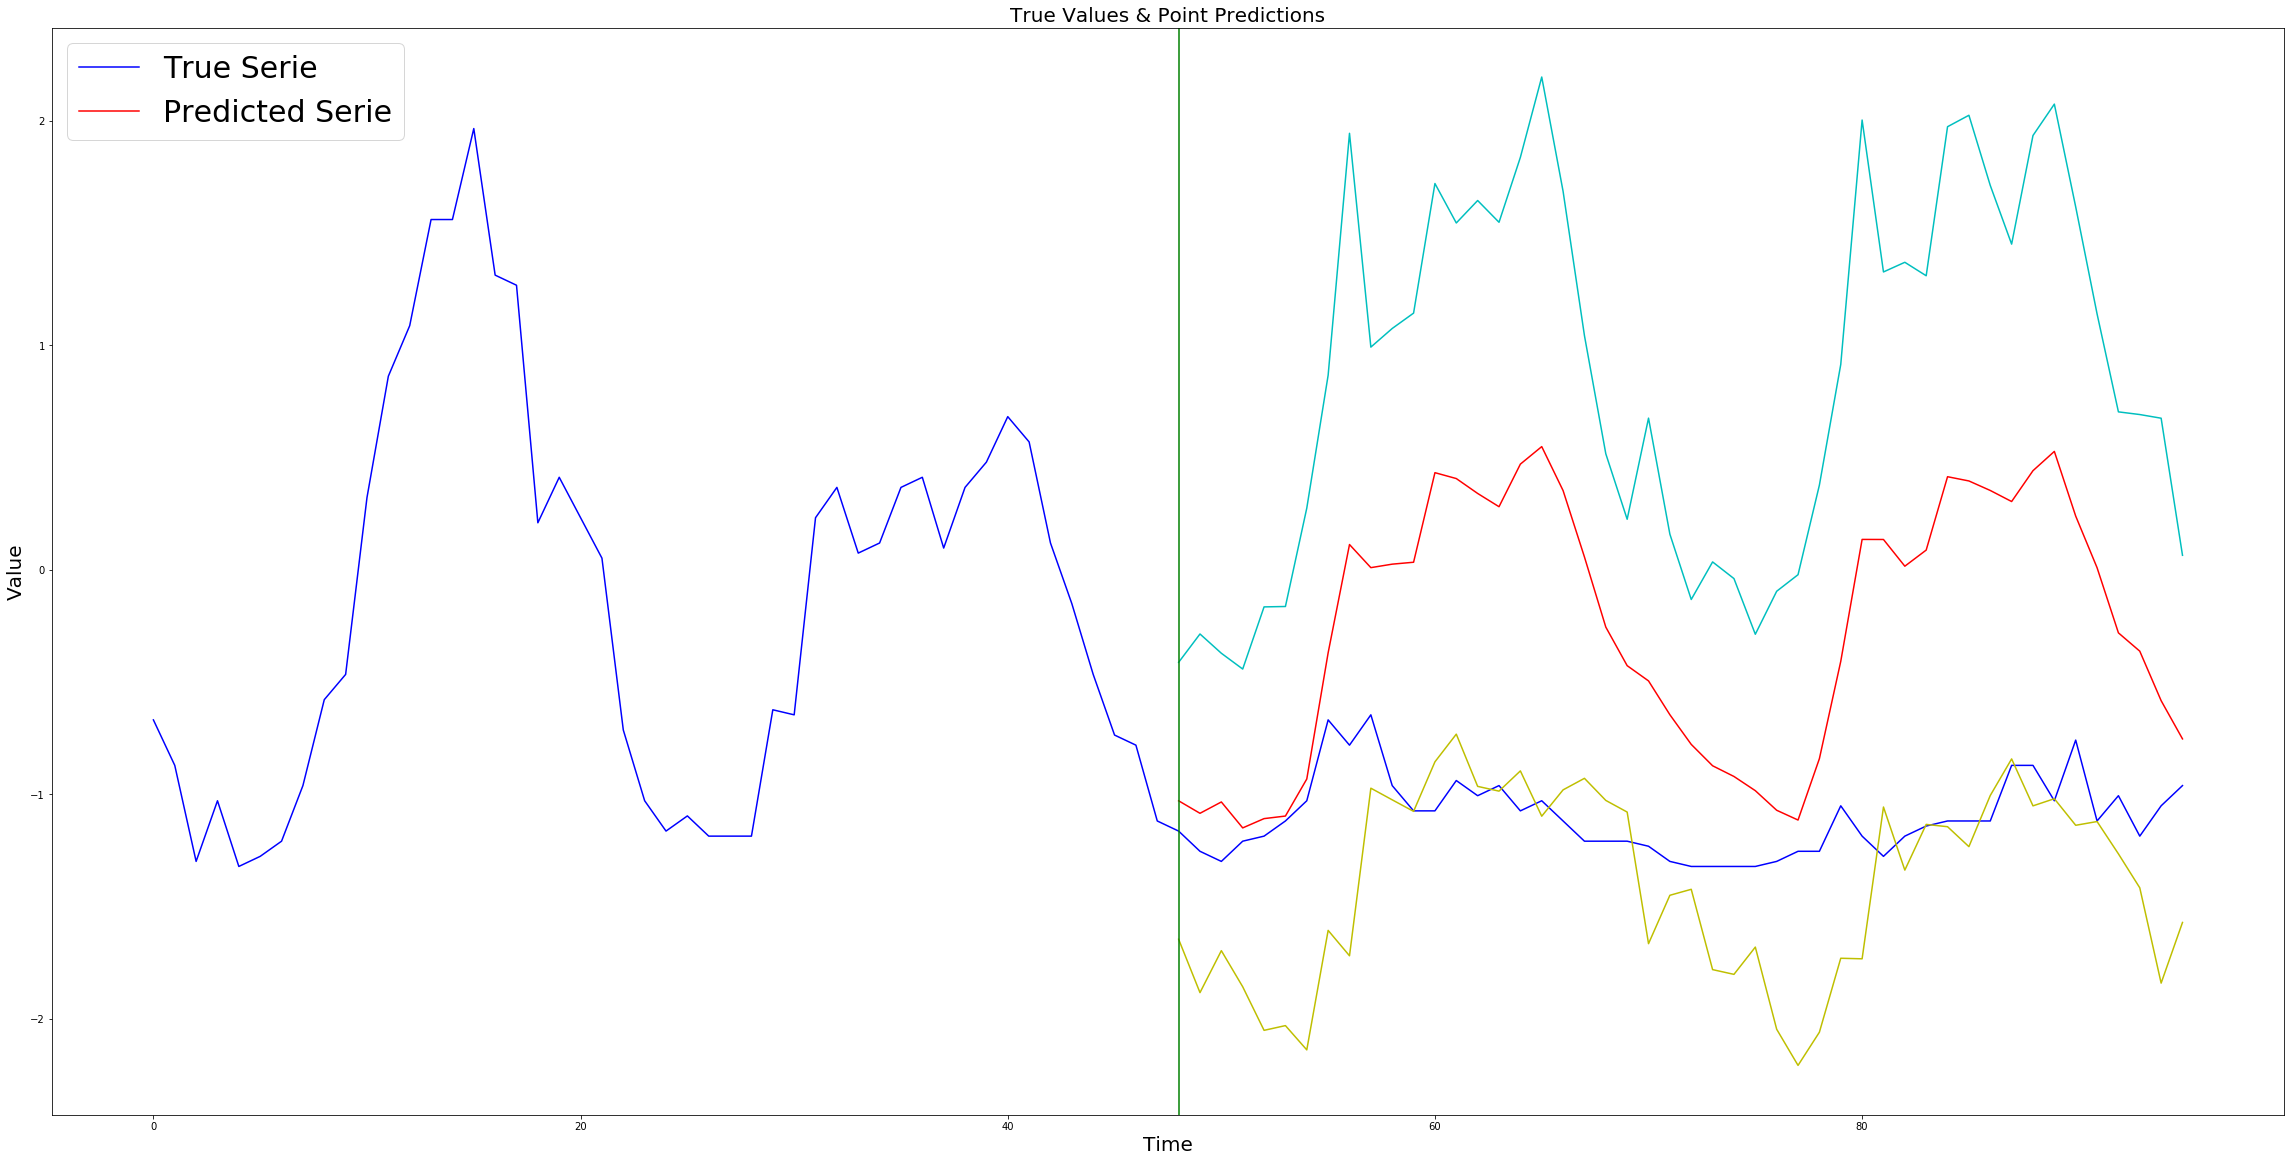

In [3]:
MODEL_BASE_DIR = '../models/kl_divergance/3-LSTM/21'
model = M4Model()
hyperparameters = model.load(MODEL_BASE_DIR)

X, Y, Ypredictions, error =  sort_by_prediction_error(model,holdout_x, holdout_y, mase)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[X.shape[0]-1]:10.4f}')

lower_bound = Ypredictions[:,:48] - 2*tf.abs(Ypredictions[:,-48:])
upper_bound = Ypredictions[:,:48] + 2*tf.abs(Ypredictions[:,-48:])

plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], lower_bound, upper_bound, serie_indx=0)
plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], lower_bound, upper_bound, serie_indx=X.shape[0]-1)

# PLot Specific Serie From A Batch

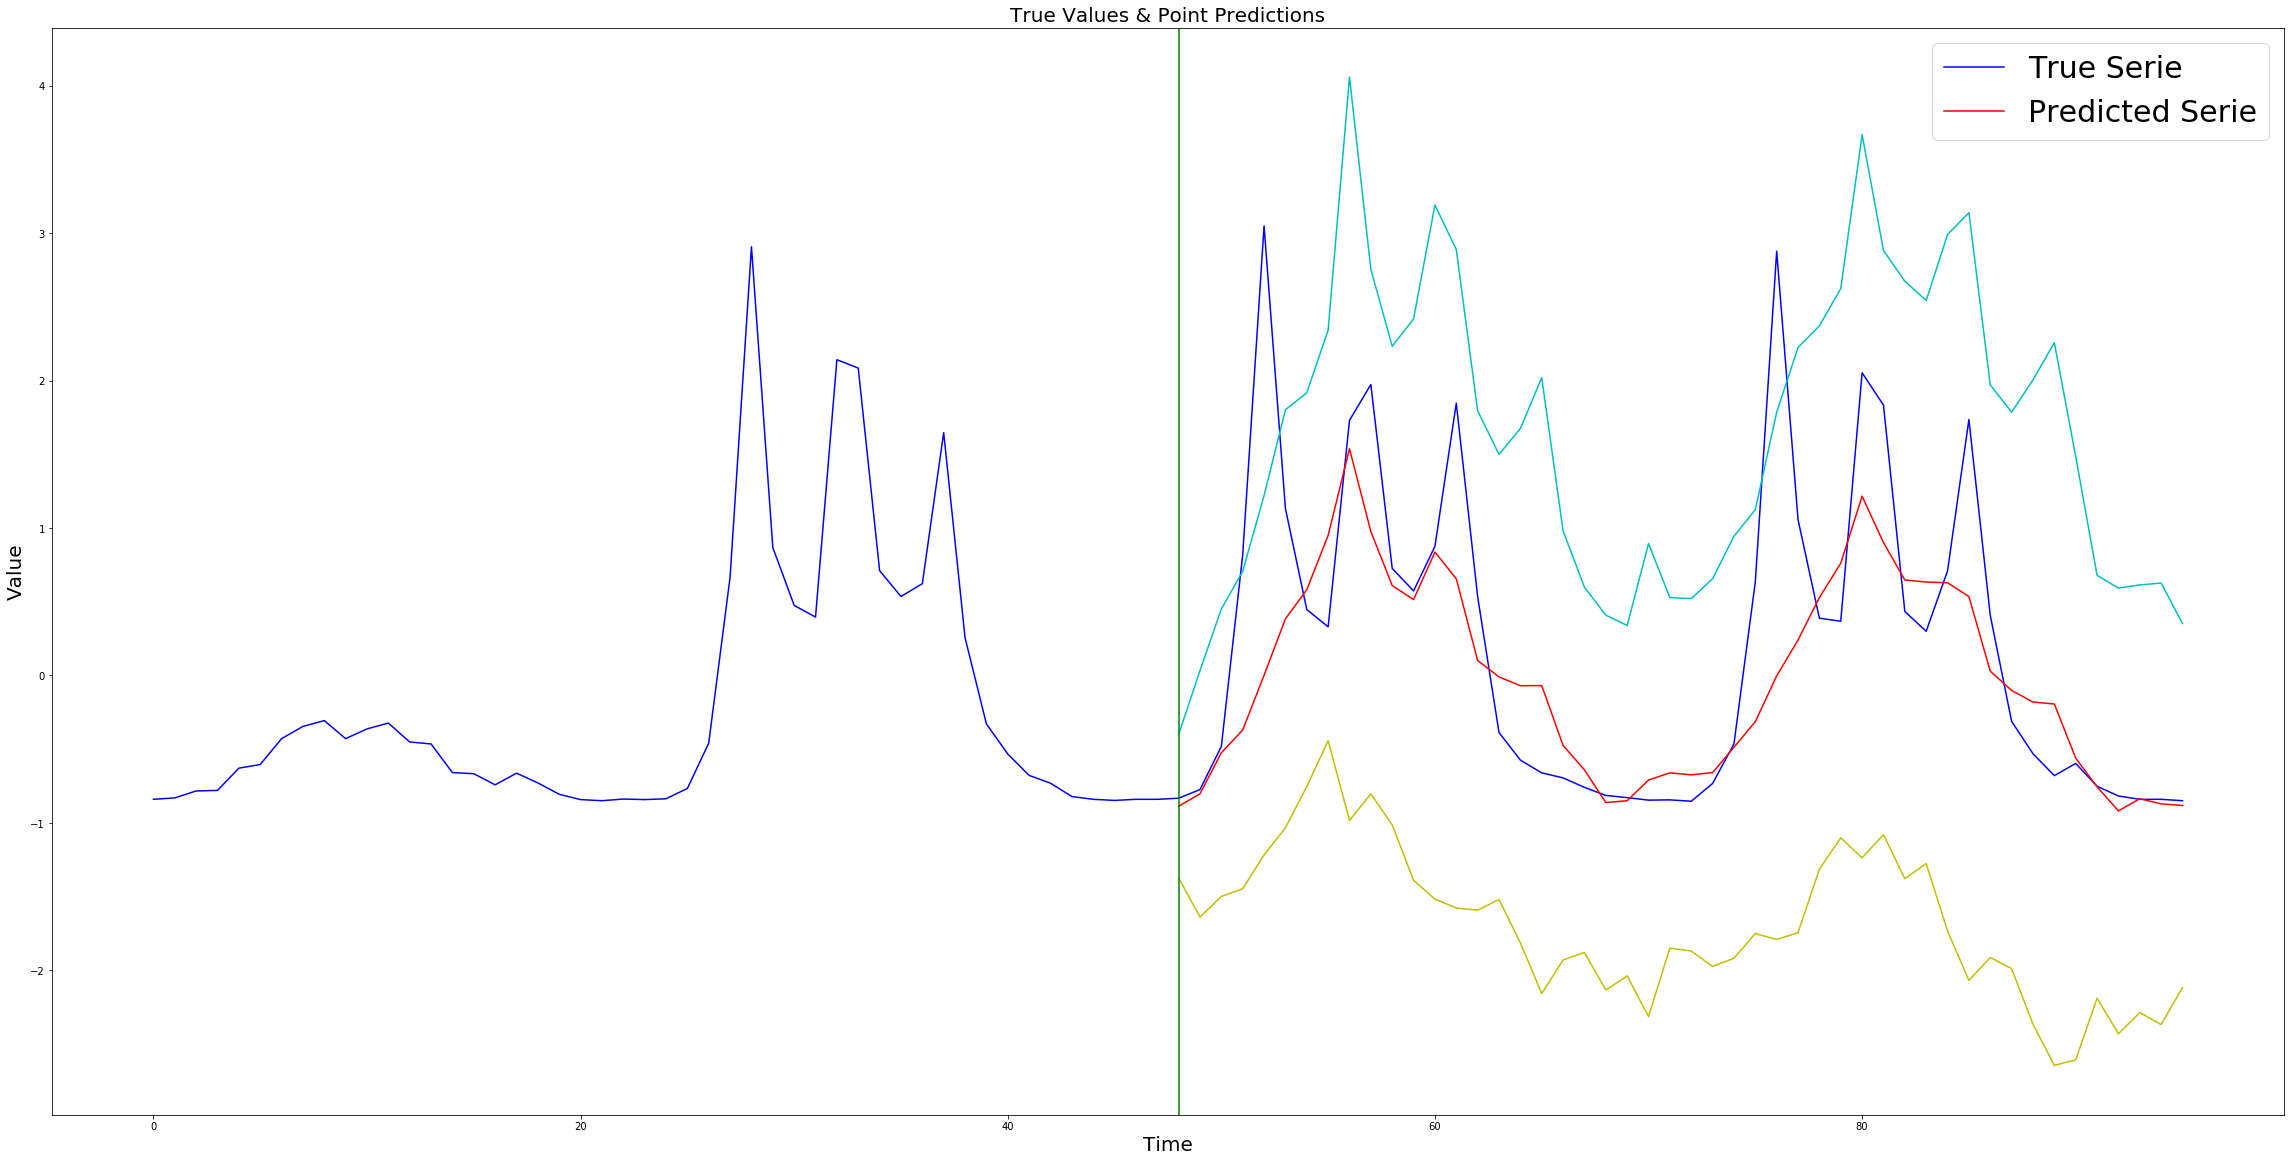

In [4]:
IDX = 139
X = test_x
Y = test_y
predictedY = model.predict(X)

lower_bound = predictedY[:,:48] - 2*tf.abs(predictedY[:,-48:])
upper_bound = predictedY[:,:48] + 2*tf.abs(predictedY[:,-48:])

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

#============ Predict Test
plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], predictedY[:,:HORIZON], lower_bound, upper_bound, serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [3]:
MODEL_NUMBER = 21
MODEL_BASE_DIR = '../models/kl_divergance/3-LSTM'
evaluation_results = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                             TRAIN_PATH, TEST_PATH, 
                                             TRAIN_HOLDOUT_PATH, TEST_HOLDOUT_PATH,
                                             x_augmentations, y_augmentations, m4_mase)

print(f'Hyperparameters : {evaluation_results["hyperparameters"]}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["test_error"]}')
print(f'Naive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_test_error"]}')
      
print(f'SNaive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_test_error"]}')

print(f'holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["holdout_error"]}')
print(f'Naive holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_holdout_error"]}')
print(f'SNaive holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_holdout_error"]}')


Loaded model from disk
Hyperparameters : {'epochs': 50, 'learning_rate': 0.01, 'batch_size': 128, 'hidden_layer_size': 30, 'lookback': 48, 'loss': 'kl_divergance', 'dropout_ratio': 0.2, 'features_number': 2, 'clipvalue': 0.5, 'output_size': 96, 'pi_params': {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}}
Test Error For Model (21) : 5.232
Naive Test Error For Model (21) : 23.825
SNaive Test Error For Model (21) : 1.805
holdout Error For Model (21) : 1.568
Naive holdout Error For Model (21) : 3.399
SNaive holdout Error For Model (21) : 1.569


# Evaluate Model PIs

In [14]:
model = M4Model()
model.load('../models/kl_divergance/3-LSTM/21')

y = test_y[:,:HORIZON]
x = test_x[:,:,0]
print(x.shape)

predictedY = model.predict(test_x)
lower_bound = predictedY[:,:HORIZON] - 2*tf.abs(predictedY[:,-HORIZON:])
upper_bound = predictedY[:,:HORIZON] + 2*tf.abs(predictedY[:,-HORIZON:])

acd_err = acd(y, lower_bound.numpy(), upper_bound.numpy())
msis_err = msis(x, y, lower_bound.numpy(), upper_bound.numpy())

#Naive
y = test_y[:,:HORIZON]
lower, upper = naive_pi(y)
n_acd_err = acd( y[:,:-1], lower, upper)
n_msis_err = msis(test_x[:,:,0],  y[:,:-1], lower, upper)

print(f'Model ACD {acd_err}')
print(f'Model MSIS {msis_err}')
print(f'Naive ACD {n_acd_err}')
print(f'Naive MSIS {n_msis_err}')

Loaded model from disk
(331, 48)
Model ACD 0.01922205438066471
Model MSIS 40.43731499623134
Naive ACD 0.047171691200102894
Naive MSIS 94.1355872482457


# Predict  And Save
Get test and holdout predictions and save them in csv files

In [15]:
predict_and_save('../models/kl_divergance/10-LSTM/2', data_loader, HORIZON)

Loaded model from disk
